In [1]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import eif 

In [289]:
with open('crafted/df_cleaned.pickle', 'rb') as handle:
    df = pickle.load(handle)
with open('crafted/sequences_1trans.pickle', 'rb') as handle:
    scaled_df = pickle.load(handle)
with open('crafted/umap_1trans.pickle', 'rb') as handle:
    umap_1trans_df = pickle.load(handle)

In [3]:
print(type(scaled_df))
scaled_df.shape

<class 'numpy.ndarray'>


(1056320, 21)

In [294]:
data = scaled_df[:100000,:]

In [74]:
extended_if = eif.iForest(data, ntrees=200, sample_size=256, ExtensionLevel=1)
%time eif_outliers_probs = extended_if.compute_paths(X_in=data)

CPU times: user 22.1 s, sys: 29.8 ms, total: 22.2 s
Wall time: 22.3 s


/home/one/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


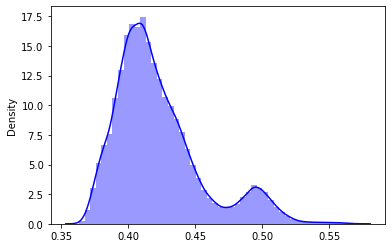

In [75]:
sns.distplot(eif_outliers_probs, kde=True, color="b")
plt.show()

98000
2000


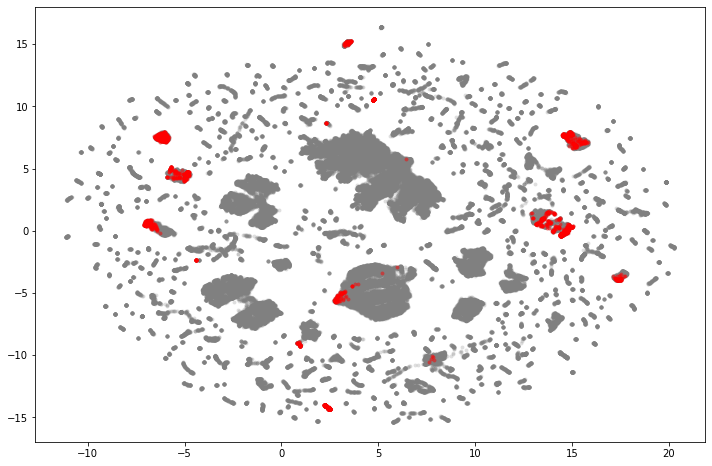

In [257]:
n_outliers = 2000
eif_outliers = eif_outliers_probs.argsort()[-n_outliers:][::-1]
eif_inliers = eif_outliers_probs.argsort()[:-n_outliers][::-1]

print(len(eif_inliers))
print(len(eif_outliers))

plt.figure(figsize=(12,8))
plt.scatter(*umap_1trans_df.T, s=15, linewidth=0, c='gray', alpha=0.25)
plt.scatter(*umap_1trans_df[eif_outliers].T, s=15, linewidth=0, c='red', alpha=0.5)
plt.show()

In [258]:
outlying = df.iloc[eif_outliers,:]
outlying['anomaly'] = 1
inlying = df.iloc[eif_inliers,:]
inlying['anomaly'] = 0

features = pd.concat([outlying.iloc[:,:-1], inlying.iloc[:,:-1]], axis=0)
features = features.drop(columns=['account_id', 'date'])
labels = pd.concat([outlying.iloc[:,-1], inlying.iloc[:,-1]], axis=0)
print(features.shape, labels.shape)


(100000, 23) (100000,)


/home/one/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/one/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [259]:
features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 79315 to 122857
Data columns (total 23 columns):
 #   Column                      Non-Null Count   Dtype
---  ------                      --------------   -----
 0   date_dayofweek              100000 non-null  int64
 1   date_day                    100000 non-null  int64
 2   date_week                   100000 non-null  int64
 3   date_month                  100000 non-null  int64
 4   date_year                   100000 non-null  int64
 5   date_days_from_last_trans   100000 non-null  int64
 6   type_credit                 100000 non-null  uint8
 7   type_withdrawal             100000 non-null  uint8
 8   type_cash                   100000 non-null  uint8
 9   op_credit_from_bank         100000 non-null  uint8
 10  op_withdrawal_from_card     100000 non-null  uint8
 11  op_credit_in_cash           100000 non-null  uint8
 12  op_withdrawal_to_bank       100000 non-null  uint8
 13  op_withdrawal_in_cash       100000 non-n

In [260]:
from sklearn.preprocessing import StandardScaler

features = pd.DataFrame(
    StandardScaler().fit_transform(features),
    index = features.index, 
    columns = features.columns
)

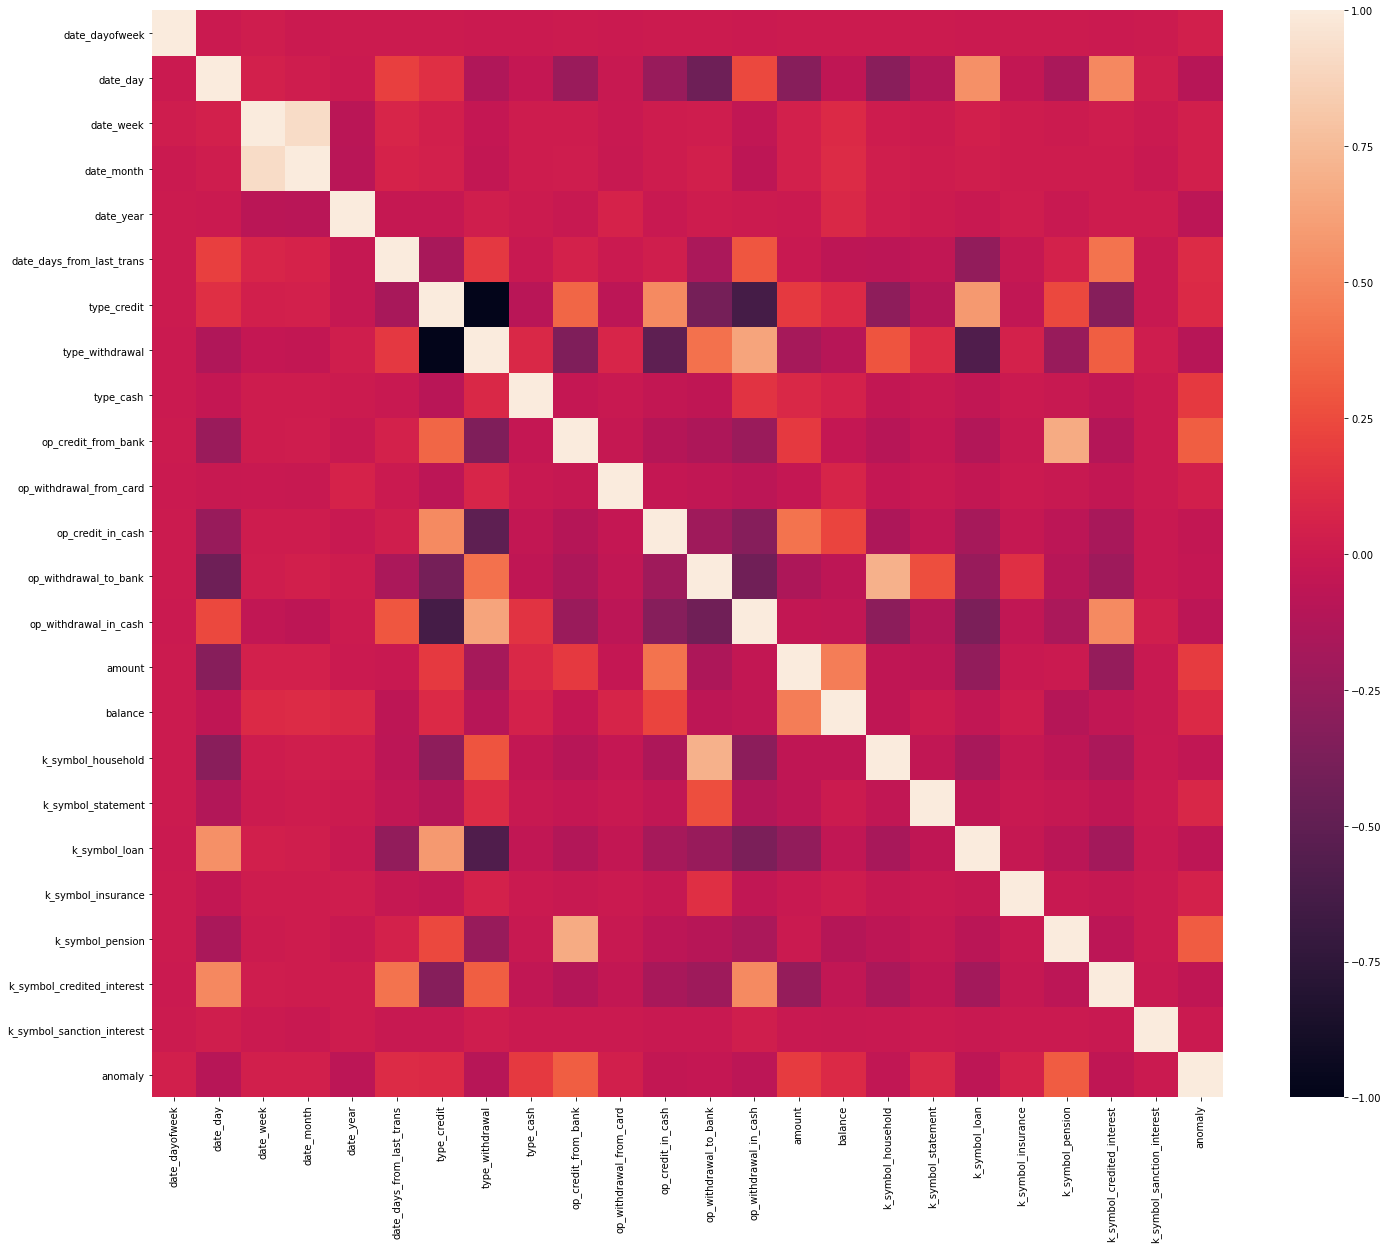

In [261]:
plt.figure(figsize=(24,20))
cor = pd.concat([features, labels], axis=1).corr(method='pearson')
sns.heatmap(cor)
plt.show()

Feature ranking:
1. amount (0.141260)
2. date_days_from_last_trans (0.139548)
3. balance (0.138207)
4. date_year (0.096114)
5. date_dayofweek (0.073401)
6. date_week (0.069108)
7. k_symbol_pension (0.068297)
8. op_credit_from_bank (0.065701)
9. date_month (0.061991)
10. date_day (0.057432)
11. type_cash (0.036042)
12. k_symbol_statement (0.015920)
13. op_credit_in_cash (0.011511)
14. k_symbol_loan (0.006335)
15. k_symbol_insurance (0.005149)
16. op_withdrawal_in_cash (0.003969)
17. type_credit (0.003399)
18. type_withdrawal (0.003154)
19. op_withdrawal_from_card (0.002057)
20. k_symbol_household (0.000613)
21. op_withdrawal_to_bank (0.000525)
22. k_symbol_credited_interest (0.000268)
23. k_symbol_sanction_interest (0.000000)


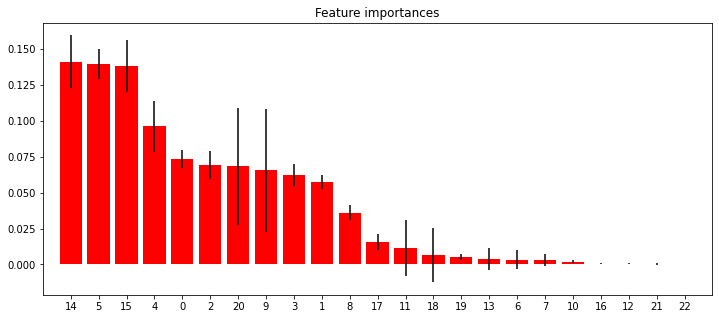

In [262]:
from sklearn.ensemble import ExtraTreesClassifier

forest = ExtraTreesClassifier(n_estimators=20,
                              random_state=0)

forest.fit(features, labels)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

print("Feature ranking:")

ordered_features = []
ordered_importances = []
for f in range(features.shape[1]):
    feature_name = features.columns[indices[f]]
    feature_importance = importances[indices[f]]
    print("%d. %s (%f)" % (f + 1, feature_name, feature_importance))
    ordered_features.append(feature_name)
    ordered_importances.append(feature_importance)

plt.figure(figsize=(12,5))
plt.title("Feature importances")
plt.bar(range(features.shape[1]), importances[indices],
        color="r", yerr=std[indices], align="center")
plt.xticks(range(features.shape[1]), indices)
plt.xlim([-1, features.shape[1]])
plt.show()

In [263]:
features.columns[indices]

Index(['amount', 'date_days_from_last_trans', 'balance', 'date_year',
       'date_dayofweek', 'date_week', 'k_symbol_pension',
       'op_credit_from_bank', 'date_month', 'date_day', 'type_cash',
       'k_symbol_statement', 'op_credit_in_cash', 'k_symbol_loan',
       'k_symbol_insurance', 'op_withdrawal_in_cash', 'type_credit',
       'type_withdrawal', 'op_withdrawal_from_card', 'k_symbol_household',
       'op_withdrawal_to_bank', 'k_symbol_credited_interest',
       'k_symbol_sanction_interest'],
      dtype='object')

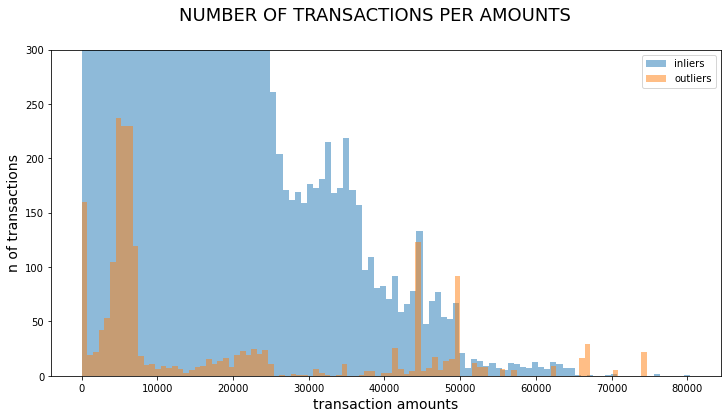

In [273]:
plt.figure(figsize=(12,6))

plt.hist(inlying['amount'], bins=100, alpha=0.5, label='inliers')
plt.hist(outlying['amount'], bins=100, alpha=0.5, label='outliers')

plt.ylim([0,300])

plt.xlabel('transaction amounts', size=14)
plt.ylabel('# transactions', size=14)
plt.suptitle('NUMBER OF TRANSACTIONS PER AMOUNTS', size=18)
plt.legend(loc='upper right')

plt.show()

In [274]:
df_anomaly = pd.concat([outlying,inlying], axis=0)
print(df_anomaly.loc[df_anomaly['anomaly']==1,'amount'].mean())
print(df_anomaly.loc[df_anomaly['anomaly']==0,'amount'].mean())

17384.0675
5385.276989795919


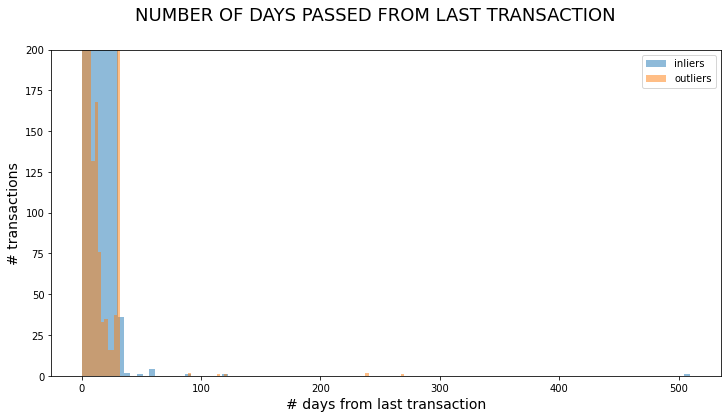

In [284]:
plt.figure(figsize=(12,6))

plt.hist(inlying['date_days_from_last_trans'], bins=100, alpha=0.5, label='inliers')
plt.hist(outlying['date_days_from_last_trans'], bins=100, alpha=0.5, label='outliers')

plt.ylim([0,200])

plt.xlabel('# days from last transaction', size=14)
plt.ylabel('# transactions', size=14)
plt.suptitle('NUMBER OF DAYS PASSED FROM LAST TRANSACTION', size=18)
plt.legend(loc='upper right')

plt.show()

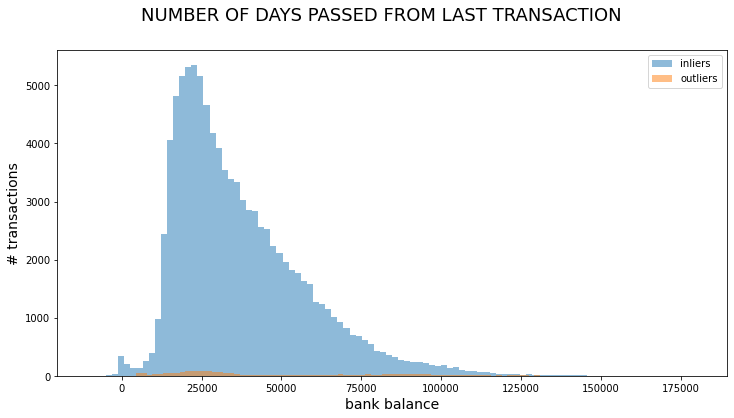

In [287]:
plt.figure(figsize=(12,6))

plt.hist(inlying['balance'], bins=100, alpha=0.5, label='inliers')
plt.hist(outlying['balance'], bins=100, alpha=0.5, label='outliers')

#plt.ylim([0,200])

plt.xlabel('bank balance', size=14)
plt.ylabel('# transactions', size=14)
plt.suptitle('NUMBER OF DAYS PASSED FROM LAST TRANSACTION', size=18)
plt.legend(loc='upper right')

plt.show()

## Analysis over 2-length transactions

In [290]:
with open('crafted/df_cleaned.pickle', 'rb') as handle:
    df = pickle.load(handle)
with open('crafted/sequences_2trans.pickle', 'rb') as handle:
    sequences_2trans = pickle.load(handle)
with open('crafted/umap_2trans.pickle', 'rb') as handle:
    umap_2trans_df = pickle.load(handle)

In [299]:
data2 = sequences_2trans.iloc[:100000,:]
data2 = StandardScaler().fit_transform(data2)


In [301]:
extended_if2 = eif.iForest(data2, ntrees=200, sample_size=256, ExtensionLevel=1)
%time eif_outliers_probs2 = extended_if.compute_paths(X_in=data2)

CPU times: user 39.4 s, sys: 214 ms, total: 39.6 s
Wall time: 39.5 s


97000
3000


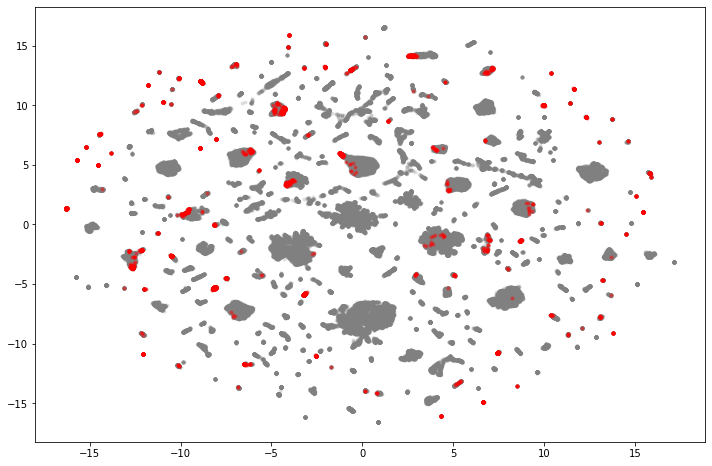

In [302]:
n_outliers2 = 3000
eif_outliers2 = eif_outliers_probs2.argsort()[-n_outliers2:][::-1]
eif_inliers2 = eif_outliers_probs2.argsort()[:-n_outliers2][::-1]

print(len(eif_inliers2))
print(len(eif_outliers2))

plt.figure(figsize=(12,8))
plt.scatter(*umap_2trans_df.T, s=15, linewidth=0, c='gray', alpha=0.25)
plt.scatter(*umap_2trans_df[eif_outliers2].T, s=15, linewidth=0, c='red', alpha=0.5)
plt.show()

In [325]:
outlying2 = sequences_2trans.iloc[eif_outliers2,:]
outlying2['anomaly'] = 1
inlying2 = sequences_2trans.iloc[eif_inliers2,:]
inlying2['anomaly'] = 0

features2 = pd.concat([outlying2.iloc[:,:-1], inlying2.iloc[:,:-1]], axis=0)
#features2 = features2.drop(columns=['account_id', 'date'])
labels2 = pd.concat([outlying2.iloc[:,-1], inlying2.iloc[:,-1]], axis=0)
print(features2.shape, labels2.shape)


(100000, 42) (100000,)


/home/one/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/one/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [326]:
features2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 7759 to 46338
Data columns (total 42 columns):
 #   Column                        Non-Null Count   Dtype 
---  ------                        --------------   ----- 
 0   0_date_dayofweek              100000 non-null  object
 1   0_date_day                    100000 non-null  object
 2   0_date_week                   100000 non-null  object
 3   0_date_year                   100000 non-null  object
 4   0_date_days_from_last_trans   100000 non-null  object
 5   0_type_credit                 100000 non-null  object
 6   0_type_cash                   100000 non-null  object
 7   0_op_credit_from_bank         100000 non-null  object
 8   0_op_withdrawal_from_card     100000 non-null  object
 9   0_op_credit_in_cash           100000 non-null  object
 10  0_op_withdrawal_to_bank       100000 non-null  object
 11  0_op_withdrawal_in_cash       100000 non-null  object
 12  0_amount                      100000 non-null  object
 1

In [327]:
from sklearn.preprocessing import StandardScaler

features2 = pd.DataFrame(
    StandardScaler().fit_transform(features2),
    index = features2.index, 
    columns = features2.columns
)

Feature ranking:
1. 1_amount (0.079471)
2. 1_balance (0.067952)
3. 0_balance (0.062933)
4. 0_amount (0.057109)
5. 0_date_year (0.049939)
6. 1_date_days_from_last_trans (0.048129)
7. 1_date_year (0.047903)
8. 1_type_cash (0.043133)
9. 0_type_cash (0.039654)
10. 0_date_days_from_last_trans (0.037314)
11. 1_op_credit_from_bank (0.035549)
12. 0_op_withdrawal_from_card (0.031159)
13. 0_date_week (0.030566)
14. 0_date_day (0.030559)
15. 0_op_credit_from_bank (0.030247)
16. 1_date_week (0.028905)
17. 1_date_day (0.026569)
18. 0_date_dayofweek (0.025039)
19. 1_date_dayofweek (0.022832)
20. 1_op_withdrawal_from_card (0.021472)
21. 1_k_symbol_pension (0.020489)
22. 0_k_symbol_statement (0.020080)
23. 0_type_credit (0.018859)
24. 0_k_symbol_pension (0.017850)
25. 0_op_withdrawal_in_cash (0.014284)
26. 1_type_credit (0.012539)
27. 0_op_credit_in_cash (0.011408)
28. 1_op_withdrawal_in_cash (0.009995)
29. 0_k_symbol_loan (0.008391)
30. 1_op_credit_in_cash (0.008221)
31. 0_op_withdrawal_to_bank (0.00

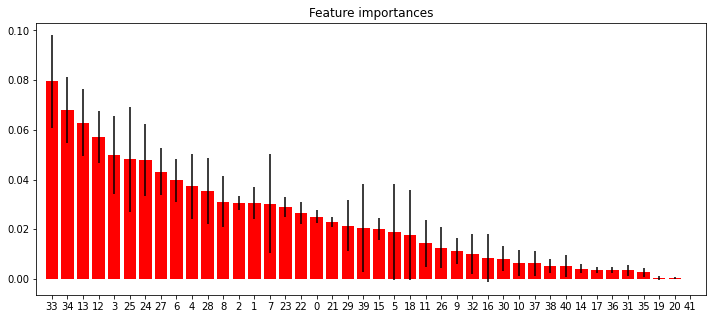

In [328]:
from sklearn.ensemble import ExtraTreesClassifier

forest = ExtraTreesClassifier(n_estimators=20,
                              random_state=0)

forest.fit(features2, labels2)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

print("Feature ranking:")

ordered_features = []
ordered_importances = []
for f in range(features2.shape[1]):
    feature_name = features2.columns[indices[f]]
    feature_importance = importances[indices[f]]
    print("%d. %s (%f)" % (f + 1, feature_name, feature_importance))
    ordered_features.append(feature_name)
    ordered_importances.append(feature_importance)

plt.figure(figsize=(12,5))
plt.title("Feature importances")
plt.bar(range(features2.shape[1]), importances[indices],
        color="r", yerr=std[indices], align="center")
plt.xticks(range(features2.shape[1]), indices)
plt.xlim([-1, features2.shape[1]])
plt.show()

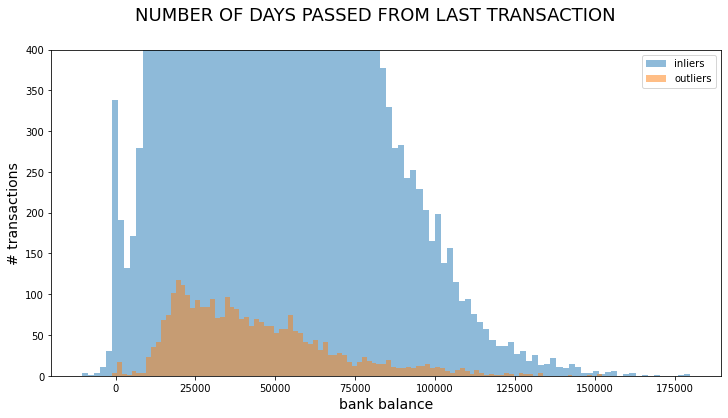

In [316]:
plt.figure(figsize=(12,6))

plt.hist(inlying2['balance'], bins=100, alpha=0.5, label='inliers')
plt.hist(outlying2['balance'], bins=100, alpha=0.5, label='outliers')

plt.ylim([0,400])

plt.xlabel('bank balance', size=14)
plt.ylabel('# transactions', size=14)
plt.suptitle('NUMBER OF DAYS PASSED FROM LAST TRANSACTION', size=18)
plt.legend(loc='upper right')

plt.show()

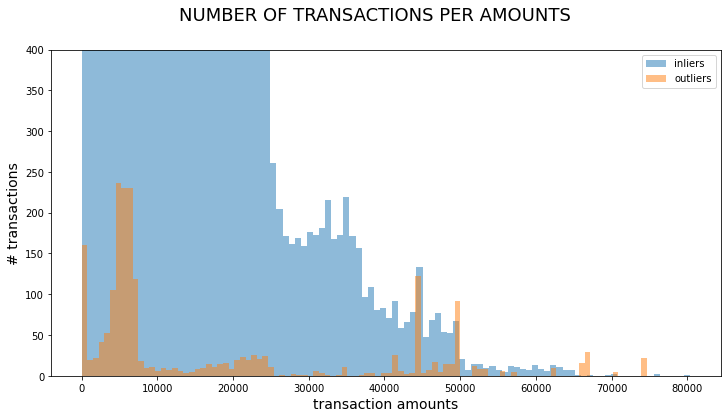

In [318]:
plt.figure(figsize=(12,6))

plt.hist(inlying['amount'], bins=100, alpha=0.5, label='inliers')
plt.hist(outlying['amount'], bins=100, alpha=0.5, label='outliers')

plt.ylim([0,400])

plt.xlabel('transaction amounts', size=14)
plt.ylabel('# transactions', size=14)
plt.suptitle('NUMBER OF TRANSACTIONS PER AMOUNTS', size=18)
plt.legend(loc='upper right')

plt.show()

In [322]:
df_anomaly2

,account_id,date_dayofweek,date_day,date_week,date_month,date_year,date_days_from_last_trans,date,type_credit,type_withdrawal,...,amount,balance,k_symbol_household,k_symbol_statement,k_symbol_loan,k_symbol_insurance,k_symbol_pension,k_symbol_credited_interest,k_symbol_sanction_interest,anomaly
trans_id,,,,,,,,,,,,,,,,,,,,,
9913,34,1,11,33,8,5,0,1998-08-11,0,1,...,20305,56850,0,0,0,0,0,0,0,1
11378,38,5,5,36,9,5,3,1998-09-05,0,1,...,228,36508,0,1,0,0,0,0,0,1
12973,43,2,3,23,6,5,3,1998-06-03,0,1,...,5160,57018,0,0,0,0,0,0,0,1
3531907,43,6,31,22,5,5,0,1998-05-31,1,0,...,286,62193,0,0,1,0,0,0,0,1
119670,401,4,20,3,1,2,6,1995-01-20,0,1,...,1200,15847,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30161,97,1,4,23,6,3,4,1996-06-04,1,0,...,4500,23374,0,0,0,0,0,0,0,0
33944,109,4,12,24,6,5,5,1998-06-12,1,0,...,16920,53624,0,0,0,0,0,0,0,0
89426,301,6,7,49,12,4,7,1997-12-07,1,0,...,2925,22050,0,0,0,0,0,0,0,0
